# __*Use Darts to predict using past covariates data*__

## __*Install packages*__

In [1]:
!pip install -q torch
!pip install -q darts
!pip install -q torchmetrics


### __*Imports*__

In [18]:
from torchmetrics.regression import MeanSquaredError
import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [ ]:
!pip install yfinance


### __*Import some example data from yfinance*__

In [6]:
'''import yfinance as yf
import pandas as pd

# List of stock symbols
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

# Set the start and end dates
start_date = '2022-01-01'
end_date = '2023-01-01'

# Retrieve hourly data for each stock
dfs = []
for stock in stocks:
    # Download data
    stock_data = yf.download(stock, start=start_date, end=end_date, interval='1h')

    # Select only the 'Close' column
    stock_data = stock_data['Close']

    # Rename the column to the stock symbol
    stock_data = stock_data.rename(stock)

    # Add to the list of DataFrames
    dfs.append(stock_data)

# Concatenate DataFrames along the columns
df = pd.concat(dfs, axis=1)
'''


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
df = pd.DataFrame(pd.read_csv('../raw_data/final_dataset.csv'))


In [6]:
df_sales = df[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']]


### __*Convert the pandas dataframe in a darts timeseries object (we need a datetime index!)*__

In [7]:
# Convert the DataFrame to a Darts TimeSeries
# Index must be datetimeindex
timeseries_all = TimeSeries.from_dataframe(df)
timeseries_sales = TimeSeries.from_dataframe(df_sales)


### __*Scale the data using the Darts sklearn wrapper*__

In [8]:
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
target_transformer = Scaler(scaler)


In [12]:
scaled_all = ts_transformer.fit_transform(timeseries_all)
scaled_sales = ts_transformer.fit_transform(timeseries_sales)

target_transformer_all = target_transformer.fit(timeseries_all[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']])
target_transformer_sales = target_transformer.fit(timeseries_sales[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']])


In [15]:
#print(target_transformer_all)
scaled_all


<TimeSeries (DataArray) (time: 15125, component: 23, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02865793],
        [0.04043964],
        [0.        ]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02763008],
        [0.04414108],
        [0.        ]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [1.        ],
        [0.24790879],
        [0.        ]],

       [[0.08      ],
        [0.05263158],
        [0.05263158],
        ...,
        [1.        ],
        [0.24790879],
        [0.        ]],

       [[0.09      ],
        [0.05263158],
        [0.10526316],
        ...,
        [1.        ],
        [0.24790879],
        [0.        ]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 ... 15119 15120 15121 15122 15123 15124
  * component  (component) object 'traditional_baguette' ... 'opinion'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Handle missing values if you have*__
### __*(in this example, weekends are not available since we are dealing with stock markets)*__

In [ ]:
'''from darts.utils.missing_values import fill_missing_values
scaled_ts = fill_missing_values(scaled_ts)
scaled_ts
'''


### __*Train Test Split*__

<Axes: xlabel='time'>

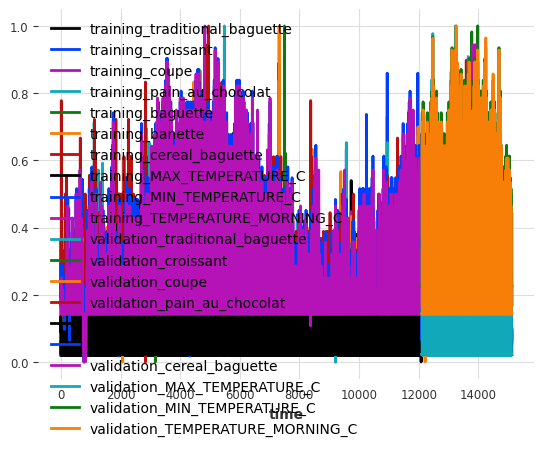

In [16]:
train, val = (scaled_all).split_before(0.8)# (we standardize by dividing by 100 since Google Trends data tops out at 100 by default!)
train.plot(label = "training")
val.plot(label = "validation")


### __*Advanced multicovariate RNN training*__

### __*Setup Earlystopping and the train on GPU*__

In [29]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
es = EarlyStopping(
    monitor = "val_loss",
    patience = 30,
    min_delta = 0.005,
    mode = 'min',
)

pl_trainer_kwargs={"callbacks": [es],
                   "accelerator": "cpu"}


### __*Instanciate our model*__

In [30]:
# predict 7 days considering the latest 28 days

model_pastcov = BlockRNNModel(
    model = "LSTM",
    input_chunk_length = 28,
    output_chunk_length = 7,
    dropout = 0.2,
    torch_metrics = MeanSquaredError(),
    n_epochs = 200,
    pl_trainer_kwargs = pl_trainer_kwargs,
    random_state = 0,
)


In [21]:
train[['traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette']]


<TimeSeries (DataArray) (time: 12099, component: 7, sample: 1)>
array([[[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.02      ],
        [0.05263158],
        [0.02631579],
        ...,
...
        ...,
        [0.15555556],
        [0.06666667],
        [0.16666667]],

       [[0.04      ],
        [0.05263158],
        [0.02631579],
        ...,
        [0.02222222],
        [0.06666667],
        [0.16666667]],

       [[0.08      ],
        [0.12280702],
        [0.10526316],
        ...,
        [0.02222222],
        [0.1       ],
        [0.22222222]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 ... 12093 12094 12095 12096 12097 12098
  * component  (component) object 'traditional_baguette' ... 'cereal_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### __*Train the model*__

In [32]:
model_pastcov.fit(
    series = [train[['traditional_baguette']]],    # the target training data
    past_covariates = train,     # the multi covariate features training data
    val_series = [val[['traditional_baguette']]],  # the target validation data
    val_past_covariates = val,   # the multi covariate features validation data
    verbose = True,
)


Epoch 6:  79%|███████▉  | 300/378 [00:26<00:07, 11.12it/s, train_loss=0.00359, val_loss=0.00472, val_MeanSquaredError=0.00472, train_MeanSquaredError=0.00302] 

### __*Do a prediction*__

Predicting: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='Datetime'>

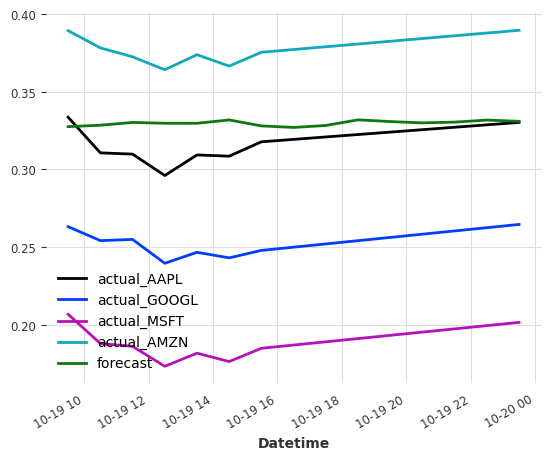

In [18]:
pred_cov = model_pastcov.predict(n=15,                        # n of days to predict
                                 series=train['AAPL'][-45:],  # target input for prediction
                                 past_covariates=train[-45:]) # past-covariates input for prediction

val[:15].plot(label="actual")
pred_cov.plot(label="forecast")


### __*Check the metrics*__

In [19]:
# check the SMAPE error

smape(val['AAPL'][:15], pred_cov)


3.6320905494796163

### __*Extract the predictions as np array in the original scale*__

In [21]:
target_transformer.inverse_transform(pred_cov).values()


array([[144.45919538],
       [144.51003158],
       [144.61066389],
       [144.58153947],
       [144.58048143],
       [144.70175457],
       [144.48565294],
       [144.43052935],
       [144.50120746],
       [144.70445222],
       [144.64298992],
       [144.59493626],
       [144.6228614 ],
       [144.6969396 ],
       [144.65217191]])